In [24]:
import numpy as np
import os
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

import tensorflow as tf
from tensorflow import keras



In [25]:
"""this is a different function than for SVM traing, things commented out"""
def Create_Data_Matrix(directory):
    i=0
    # Must call sort on directory
    for file in sorted(os.listdir(directory)): 
        filename = directory+'/'+file

        # Loads image, converts to grayscale and resizes it to a 300x300 image
        #y = np.array(Image.open(filename).convert('RGB').resize((300,300)))
        y = np.array(Image.open(filename).convert('RGB'))

        #Resizes 300x300 image to 90,000x1 array
        col_y = y.ravel()[:,np.newaxis]

        # Saves
        if i==0:
            data = col_y
            #data = y
        else:
            data = np.hstack((data, col_y))
            #data = np.hstack((data, y))

        # Plots image
        """
        plt.figure(figsize=(5,5))
        plt.imshow(y, cmap='gray')
        plt.xticks([]),plt.yticks([])
        plt.show();
        """
        
        i+=1
        
    return data

In [26]:
def Create_Labels_Matrix(directory):
    i=0
    for file in sorted(os.listdir(directory)):
        filename = directory+'/'+file
        
        tree = ET.parse(filename)
        root = tree.getroot()
        sample_annotations = []
        for neighbor in root.iter('bndbox'):
            xmin = int(neighbor.find('xmin').text)
            ymin = int(neighbor.find('ymin').text)
            xmax = int(neighbor.find('xmax').text)
            ymax = int(neighbor.find('ymax').text)
            sample_annotations.append([xmin, ymin, xmax, ymax])
            if i==0:
                data = sample_annotations
            else:
                data = np.vstack((data, sample_annotations))
            break;
        i+=1
        
    return data


In [27]:
def Resize_Before_Training(flattened):
    i = 0
    for x in flattened:
        temp = x.reshape((1,720,1280,3)) # #300,300,3
    
        if i < 6:    
            plt.figure(figsize=(5,5))
            plt.imshow(temp[0], cmap='gray') # temp[0] to actually get img
            plt.xticks([]),plt.yticks([])
            plt.show();
    
        if i == 0:
            data = temp
        else:
            data = np.vstack((data,temp))
    
        i+=1
    
    return data
    

In [28]:
def convert_Bbox_to_int(prediction):
    rounded_int_list = [int(round(x)) for x in prediction]
    array_int = np.array(rounded_int_list, dtype='int')
    return array_int

In [29]:
def convert_floatMatrix_to_int(predMatrix, resolution):
    # pass in prediction matrix directly 
    final = predMatrix.copy()
    final = predMatrix*resolution
    for idx in range(len(final)):
        final[idx]=convert_Bbox_to_int(final[idx])
    return final

In [30]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-11-02 18:25:27.272001: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 18:25:33.603647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 75955 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


True

In [ ]:
"""Creating the data matrix (LOCAL)"""

#!! Suggestion: extra pictures later in dimmed light: this is critical for extra accuracy 

#using absolute paths in order to save OneDrive Space (don't want it to just fill with training pics)
bottleCap_pics=r"C:/Users/plani/Documents/Design2 Pics/cap/imgs"
bottleCap_labels=r"C:/Users/plani/Documents/Design2 Pics/cap/labels"

lighter_pics=r"C:/Users/plani/Documents/Design 1/ML repo/copy/MachineLearning/ML pics/Lighter"
lighter_labels=r"C:/Users/plani/Documents/Design2 Pics/lighter/labels"

emptyClass_pics = r"C:/Users/plani/Documents/Design2 Pics/empty"

bottleCap_array = Create_Data_Matrix(bottleCap_pics)
lighter_array = Create_Data_Matrix(lighter_pics)
emptyClass_array = Create_Data_Matrix(emptyClass_pics)

bottleCap_boxArray = Create_Labels_Matrix(bottleCap_labels)
lighter_boxArray = Create_Labels_Matrix(lighter_labels)

In [ ]:
"""Creating the data matrix FROM DESIGN 1 PICS (ON HIPER-GATOR)"""

# bottleCap_pics_HP = r'Design2 Pics/cap/imgs'
# bottleCap_labels_HP = r"Design2 Pics/cap/labels"

# lighter_pics_HP = r"Design2 Pics/lighter/imgs"
# lighter_labels_HP = r"Design2 Pics/lighter/labels"

# emptyClass_pics_HP = r"Design2 Pics/empty"

# bottleCap_array = Create_Data_Matrix(bottleCap_pics_HP)
# lighter_array = Create_Data_Matrix(lighter_pics_HP)
# emptyClass_array = Create_Data_Matrix(emptyClass_pics_HP)

# bottleCap_boxArray = Create_Labels_Matrix(bottleCap_labels_HP)
# lighter_boxArray = Create_Labels_Matrix(lighter_labels_HP)

In [31]:
"""Creating the data matrix FROM ROS PICS (ON HIPER-GATOR)"""

# bottleCap_pics_HP = r'Design2 Pics/cap/imgs'
# bottleCap_labels_HP = r"Design2 Pics/cap/labels"

lighter_pics_HP = r"ExperimentPicsCollection/rosPics/FULL_lighter_pics"
lighter_labels_HP = r"ExperimentPicsCollection/rosPics/labels_lighter_robot_pics_2023-11-01-23_XML"

emptyClass_pics_HP = r"ExperimentPicsCollection/rosPics/rospics_empty"

# bottleCap_array = Create_Data_Matrix(bottleCap_pics_HP)
lighter_array = Create_Data_Matrix(lighter_pics_HP)
emptyClass_array = Create_Data_Matrix(emptyClass_pics_HP)

# bottleCap_boxArray = Create_Labels_Matrix(bottleCap_labels_HP)
lighter_boxArray = Create_Labels_Matrix(lighter_labels_HP)

In [32]:
# 133 bottle cap images, each img rescaled to 300x300 and ravel() called = 90k. Since each pixel has 3 channels RGB, it is
# 90k * 3 = 270k

# print("bottle cap array size:",bottleCap_array.shape)
print("lighter array size:",lighter_array.shape)
print("empty class array size",emptyClass_array.shape)

# print("bottle cap label array size:",bottleCap_boxArray.shape)
print("lighter label array size:",lighter_boxArray.shape)


lighter array size: (2764800, 250)
empty class array size (2764800, 158)
lighter label array size: (250, 4)


In [33]:
"""X : FEATURE MATRIX """ 
X = np.hstack(( lighter_array, emptyClass_array)).T

# stack all arrays together, no requirment to have same amount of images per class. But of course more images
# necessary for 'empty class', only 67 now 
#print("*Note: 142,800/300 = 476. Shape of X: ", X.shape)
X.shape

(408, 2764800)

In [34]:
"""T : Target MATRIX: Bounding Boxes """ 
empty_boxArray = np.zeros( (emptyClass_array.shape[1],4))
T = np.vstack(( lighter_boxArray, empty_boxArray))
T.shape

(408, 4)

In [35]:
"""t: TARGET MATRIX for Classification"""
# Integer encoding for the class labels, may want to experiment with one-hot encoding(part of cross validation)
# Also order here matters because the feature matrix(imgs) were stacked in this order as well
t = np.hstack( (1*np.ones(lighter_array.shape[1]) , np.zeros(emptyClass_array.shape[1])) ) #(np.ones(bottleCap_array.shape[1]),

t.shape

(408,)

In [36]:
"""Train Test Split for Feature Matrix"""
# Normalization: divide by pixel max value then all values [0,1]
#X =X/255.

# here I need to setup Cross Validation, look back at notes, vary the kernel function for the model below 
X_train, X_test, t_train, t_test = train_test_split(X, T, test_size=0.2, random_state=42, stratify=t)

X_train.shape, X_test.shape, t_train.shape, t_test.shape

((326, 2764800), (82, 2764800), (326, 4), (82, 4))

In [14]:
"""NOTE: Need to write simple function to get back integer values for coordinates """
type(T[0][0]), T[0]

(numpy.float64, array([621., 312., 660., 324.]))

In [15]:
"""NOTE: Origional array is is still int """
lighter_boxArray[33]

array([646, 349, 743, 396])

In [16]:
extra =  lighter_boxArray[33] 
#extra = np.reshape(extra, (1,4))
extra.shape

(4,)

In [17]:
extra

array([646, 349, 743, 396])

In [18]:
"""NOTE: need tuple if want to draw using Image (PILLOW)"""
extra = tuple(extra)
extra

(646, 349, 743, 396)

In [19]:
single = lighter_array.copy().T
aPic = single[33].reshape((720,1280,3))
# plt.figure(figsize=(8,8))
# plt.imshow(aPic, cmap="gray")
# plt.show()

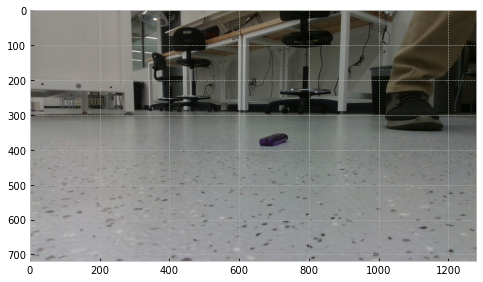

In [20]:
PIL_image = Image.fromarray(aPic)
#PIL_image = PIL_image.transpose(Image.ROTATE_270)
plt.figure(figsize=(8,8))
plt.imshow(PIL_image, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

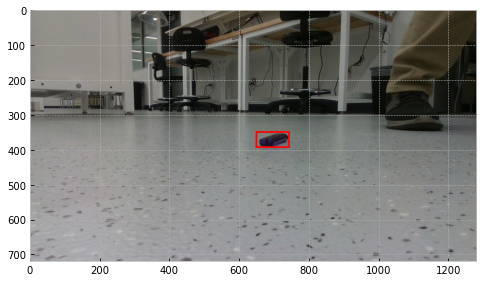

In [21]:
bbox = lighter_boxArray[0]
img_annotated = PIL_image.copy()
img_bbox = ImageDraw.Draw(img_annotated)
# for coords in bbox:
#     print(coords)
# img_bbox.rectangle(bbox, outline="red", width=5)
#img_bbox.rectangle((646, 349, 743, 396), outline="red", width=5)
img_bbox.rectangle(extra, outline="red", width=5)


plt.figure(figsize=(8,8))
plt.imshow(img_annotated, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

In [22]:
X_train[0].shape

(2764800,)

In [23]:
one = X_train[0].reshape((720,1280,3))
one.shape

(720, 1280, 3)

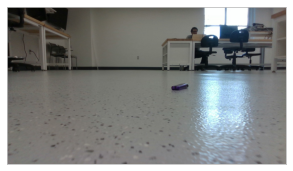

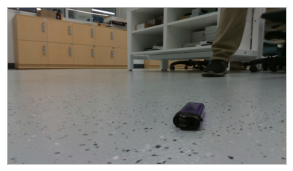

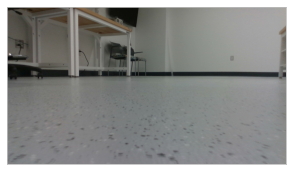

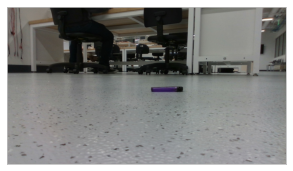

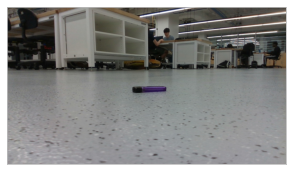

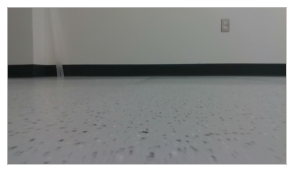

In [37]:
X_train_R = Resize_Before_Training(X_train)

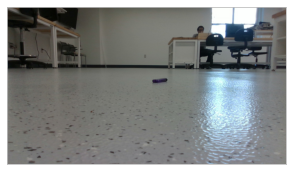

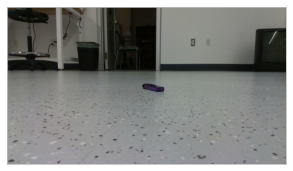

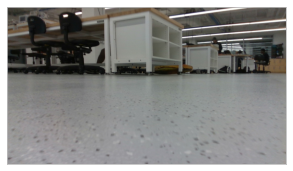

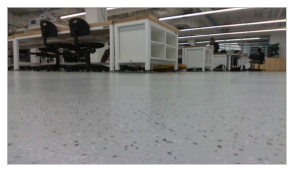

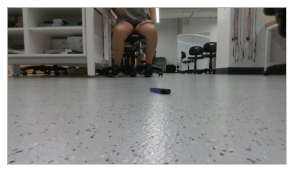

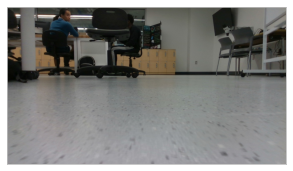

In [38]:
X_test_R = Resize_Before_Training(X_test)

In [39]:
""" Reshaped and Ready for input into model """
X_train_R.shape, X_test_R.shape

((326, 720, 1280, 3), (82, 720, 1280, 3))

In [40]:
t_train.shape, t_test.shape

((326, 4), (82, 4))

In [41]:
"""NOTE: must normalize lable data as well, do it by maximum resolution value"""
t_train = t_train/1280
t_test = t_test/1280

In [42]:
type(X_train[0][0])

numpy.uint8

In [43]:
img_height = 720
img_width = 1280
batch_size = 32

In [63]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,img_width,3)),
    keras.layers.RandomRotation(factor=0.15),
    keras.layers.RandomZoom(height_factor=0.1),
    keras.layers.RandomContrast((0.3,0.1))
    
  ]
)

2023-11-02 12:40:05.576735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [ ]:
n_single = X[5].reshape(1,300,300,3) # must be this size for data_aug processing to work 
plt.figure(figsize=(8, 8))
plt.imshow(n_single[0].astype("uint8"))
plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))

augmented_images = data_augmentation(n_single)
plt.imshow(augmented_images[0].numpy().astype("uint8"))
plt.axis("off")
#plt.minorticks_off

In [44]:
"""Constructing Regression CNN/MLP Model """
model = keras.models.Sequential([
    keras.layers.Input(shape=(img_height,img_width,3) ) ,
    #data_augmentation,
    keras.layers.Rescaling(1./255 ), 
    #keras.layers.Input(shape=(300,300,3) ) , 
    #keras.layers.Conv2D(4, 7, activation='relu', padding='same' , input_shape=[300, 300, 3]), 
    keras.layers.Conv2D(4, 7, activation='relu', padding='same'), # params: (filter count, kernelsize(pixel for kernel) ... ) 
    keras.layers.MaxPooling2D(2), # experiment to maybe remove
    keras.layers.Conv2D(8, 8, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    # starting MLP layer
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(4, activation='softplus')  #4 for four coordinates, softplus to ensure positive outputs
])



2023-11-02 18:26:31.171106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 75955 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [45]:
"""Compiling Classifier """
# model.compile(loss=keras.losses.mse,   #MSE or MAE for regression task?
#              optimizer=keras.optimizers.Adam(learning_rate=0.001),
#              metrics=['mean_squared_error']) # could track mae if i want here 
# model.compile(loss=keras.losses.mse,   #MSE or MAE for regression task?
#              optimizer=keras.optimizers.Adam(learning_rate=0.001),
#              metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]) 

model.compile(loss=keras.losses.mse,   #MSE or MAE for regression task?
             optimizer=keras.optimizers.Adam(learning_rate=0.001)) 

In [46]:
# history = model.fit(X_train_R, t_train, epochs=100, batch_size=32,
#          validation_data=(X_test_R, t_test),
#          callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # callback: 5 steps with no improvment = stop

history = model.fit(X_train_R, t_train, epochs=15, batch_size=32,
         validation_data=(X_test_R, t_test)) 

Epoch 1/15


2023-11-02 18:26:44.125491: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-11-02 18:26:54.163013: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11/11 [==============================] - 19s 240ms/step - loss: 0.1436 - val_loss: 0.1378
Epoch 2/15
11/11 [==============================] - 1s 101ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 3/15
11/11 [==============================] - 1s 120ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 4/15
11/11 [==============================] - 1s 122ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 5/15
11/11 [==============================] - 2s 160ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 6/15
11/11 [==============================] - 1s 87ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 7/15
11/11 [==============================] - 1s 85ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 8/15
11/11 [==============================] - 1s 84ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 9/15
11/11 [==============================] - 1s 85ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 10/15
11/11 [==============================] - 1s 113ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 11/15
1

In [47]:
y_train = model.predict(X_train_R)
y_test = model.predict(X_test_R)

numpy.ndarray

In [29]:
y_train_converted = convert_floatMatrix_to_int(y_train, 1280)
y_test_converted = convert_floatMatrix_to_int(y_test, 1280)

In [30]:
i=0
for coord in y_train_converted:
    if i > 139 and i < 150:
        print(coord)
    if i == 150:
        break 
    i+=1
    

[677. 343. 723. 350.]
[586. 345. 678. 400.]
[667. 362. 757. 423.]
[495. 326. 597. 366.]
[594. 352. 676. 404.]
[13. 14. 13. 12.]
[7. 7. 6. 8.]
[754. 304. 850. 399.]
[15. 16. 14. 17.]
[622. 362. 759. 410.]


In [31]:
i=0
t_trainMult=t_train*1280
for coord in t_trainMult:
    if i > 139 and i < 150:
        print(coord)
    if i == 150:
        break 
    i+=1

[676. 320. 751. 348.]
[586. 342. 677. 393.]
[674. 358. 760. 397.]
[483. 328. 548. 353.]
[622. 337. 696. 393.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[742. 350. 842. 382.]
[0. 0. 0. 0.]
[610. 358. 770. 402.]


In [32]:
y_train_converted[142]

array([667., 362., 757., 423.], dtype=float32)

In [33]:
y_train_converted[142], t_trainMult[142]

(array([667., 362., 757., 423.], dtype=float32),
 array([674., 358., 760., 397.]))

In [34]:
bbox = tuple(convert_Bbox_to_int(y_train_converted[142]))
bbox

(667, 362, 757, 423)

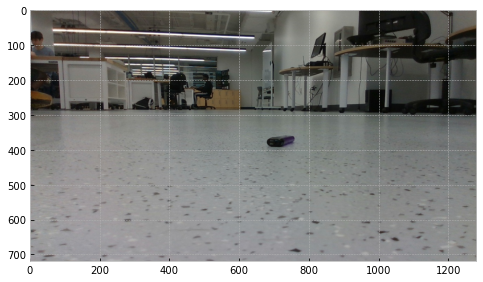

In [35]:
img_train = Image.fromarray(X_train_R[142])
#PIL_image = PIL_image.transpose(Image.ROTATE_270)
plt.figure(figsize=(8,8))
plt.imshow(img_train, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

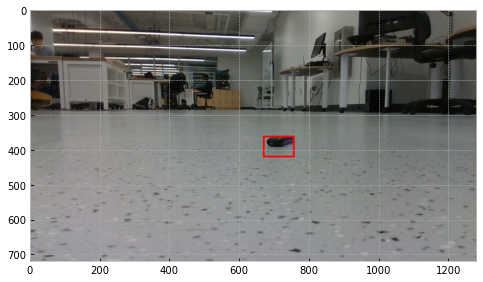

In [36]:
#bbox = tuple(floater)
img_annotated = img_train.copy()
img_bbox = ImageDraw.Draw(img_annotated)
# for coords in bbox:
#     print(coords)
# img_bbox.rectangle(bbox, outline="red", width=5)
#img_bbox.rectangle((646, 349, 743, 396), outline="red", width=5)
img_bbox.rectangle(bbox, outline="red", width=5)


plt.figure(figsize=(8,8))
plt.imshow(img_annotated, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

In [37]:
y_test_converted.shape

(82, 4)

In [38]:
i=0
for coord in y_test_converted:
    if i > 49 and i < 64:
        print(coord)
    if i == 64:
        break 
    i+=1
    

[502. 338. 722. 358.]
[713. 429. 831. 481.]
[14. 15. 12. 18.]
[710. 392. 722. 417.]
[737. 380. 867. 431.]
[126.  61. 158.  80.]
[481. 407. 671. 394.]
[165. 109. 187.  97.]
[ 94.  53. 103.  60.]
[30. 31. 41. 36.]
[454. 349. 520. 264.]
[15. 20. 15. 16.]
[3. 4. 2. 3.]
[6. 7. 5. 7.]


In [39]:
i=0
t_testMult=t_test*1280
for coord in t_testMult:
    if i > 49 and i < 64:
        print(coord)
    if i == 64:
        break 
    i+=1
    

[640. 430. 917. 595.]
[741. 420. 894. 571.]
[0. 0. 0. 0.]
[622. 307. 662. 322.]
[772. 360. 888. 420.]
[750. 325. 793. 339.]
[634. 345. 791. 398.]
[ 979.  329. 1040.  363.]
[813. 336. 881. 357.]
[0. 0. 0. 0.]
[594. 360. 754. 401.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


In [40]:
testNum = 54

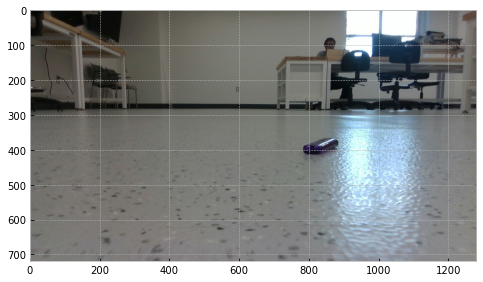

In [41]:
img_test = Image.fromarray(X_test_R[testNum])
#PIL_image = PIL_image.transpose(Image.ROTATE_270)
plt.figure(figsize=(8,8))
plt.imshow(img_test, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

In [42]:
bbox_test = tuple(convert_Bbox_to_int(y_test_converted[testNum]))
bbox_test

(737, 380, 867, 431)

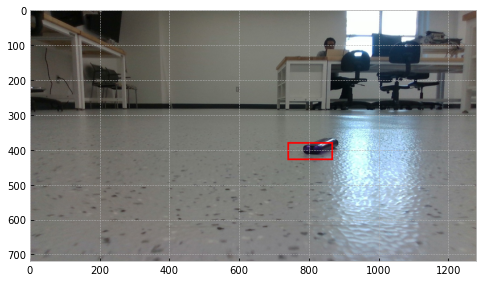

In [43]:
img_annotated = img_test.copy()
img_bbox = ImageDraw.Draw(img_annotated)
# for coords in bbox:
#     print(coords)
# img_bbox.rectangle(bbox, outline="red", width=5)
#img_bbox.rectangle((646, 349, 743, 396), outline="red", width=5)
img_bbox.rectangle(bbox_test, outline="red", width=5)


plt.figure(figsize=(8,8))
plt.imshow(img_annotated, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

In [139]:
type(img_test)

PIL.Image.Image

In [42]:
one = np.array(img_test)
one.shape

(720, 1280, 3)

In [44]:
#directory = lighter_pics_HP + "/173.JPG"
directory = 'ExperimentPicsCollection/rosPics/FULL_lighter_pics/173.jpg'

In [60]:
two = cv2.imread(directory)
type(one)

numpy.ndarray

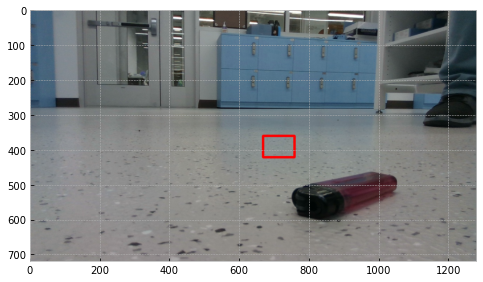

In [61]:
"""THIS IS THE CORRECT WAY TO DO IT"""

plt.figure(figsize=(8,8))
cv2.rectangle(two, (bbox[0], bbox[1]), (bbox[2], bbox[3]),(255,0,0), 5) 
#cv2.rectangle(one, (775, 450), (1100, 600),(255,0,0), 5)
plt.imshow(two, cmap='gray')
plt.show();

In [54]:
bbox

(667, 362, 757, 423)

In [55]:
single = y_train[6]
single

array([0., 0., 0., 0.], dtype=float32)

In [57]:
y_test

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


In [ ]:
PIL_image = Image.fromarray(np.uint8(one[0])).convert('RGB')
PIL_image = PIL_image.transpose(Image.ROTATE_270)
plt.figure(figsize=(5,5))
plt.imshow(PIL_image, cmap='gray')
plt.xticks([]),plt.yticks([])
plt.show();

In [137]:
import tensorflow_model_optimization as tfmot

ModuleNotFoundError: No module named 'tensorflow_model_optimization'

In [138]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 720, 1280, 3)      0         
                                                                 
 conv2d (Conv2D)             (None, 720, 1280, 4)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 360, 640, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 360, 640, 8)       2056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 180, 320, 8)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 460800)            0

In [40]:
"""Storing Model in Keras format"""
model.save('finalModel1_a.keras')

In [ ]:
"""Storing Model in SavedModel format"""
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
"""Notes/Testing cells below"""

In [ ]:
#Testing: this is what Resize_Before_Training() will do 
gatr = np.ones((1,300,300,3))
gatr2 = 2*np.ones((1,300,300,3))
#gatr = gatr[np.newaxis, :]
gatrs = np.vstack((gatr,gatr2))
gatrs.shape


In [ ]:
floater = y_train[33]*1280
floater

In [ ]:
converted = convert_Bbox_to_int(floater)
converted

In [ ]:
rounded_int_list = [int(round(x)) for x in floater]
array_int = np.array(rounded_int_list, dtype='int')
array_int

In [22]:
testing = tuple((5, 6, 3, 2))
#testing = [5,6,3,2]
if testing[0] < 6 and testing[1] < 7:
    print("good")
else:
    print ("bad")
    

good


In [23]:
testing[5]

IndexError: tuple index out of range

In [18]:
testing = np.array(testing)

In [19]:
for (x, y, w, h) in testing:
    print(x)
    print(y)
    print(w)
    print(h)

TypeError: cannot unpack non-iterable numpy.int64 object

In [20]:
test = str(testing)
test

'[5 6 3 2]'

In [ ]:
testing[]